In [1]:
!pip install transformers datasets evaluate rouge_score

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d730da8254b170a2a44a380f9f8d07f4c3d64294c171855ba70aa17d4d934051
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
from datasets import load_dataset, DatasetDict
from transformers import DataCollatorForSeq2Seq
from transformers import AutoTokenizer
from transformers import create_optimizer, AdamWeightDecay
import numpy as np
from transformers import TFAutoModelForSeq2SeqLM
import evaluate
import tarfile

In [3]:
!pip install gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get the DRIVE_ID from the environment variables
drive_id = os.getenv('DRIVE_ID')

# Use the drive_id in the gdown command
!gdown --id {drive_id}

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kO8drH_2JwEcTlfQqEj40ct3_DUH5wcf
From (redirected): https://drive.google.com/uc?id=1kO8drH_2JwEcTlfQqEj40ct3_DUH5wcf&confirm=t&uuid=05d63b8e-34e7-4f84-9f5b-26a529ec0165
To: /kaggle/working/Copy of liputan6_data.tar.gz
100%|█████████████████████████████████████████| 165M/165M [00:01<00:00, 130MB/s]


In [5]:
import tarfile
file_path = "./Copy of liputan6_data.tar.gz"
tar = tarfile.open(file_path, "r:gz")
tar.extractall()
tar.close()
print("File extracted successfully!")

File extracted successfully!


In [6]:
# Load the dataset
data = load_dataset("id_liputan6", 'canonical', data_dir="./liputan6_data", trust_remote_code=True)

id_liputan6.py:   0%|          | 0.00/6.73k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10972 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10972 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/193883 [00:00<?, ? examples/s]

In [7]:
data = DatasetDict({
    'train': data['train'].select(range(30000)),
    'validation': data['validation'].select(range(1500)),
    'test': data['test'].select(range(1500))
})

In [8]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary'],
        num_rows: 1500
    })
})

In [9]:
data['train'][4]

{'id': '26413',
 'url': 'https://www.liputan6.com/news/read/26413/ratusan-hektare-sawah-dan-tambak-terendam-air',
 'clean_article': 'Liputan6.com, Jambi: Ratusan hektare sawah dikhawatirkan hancur, menyusul banjir yang melanda berbagai wilayah di Jambi, sejak dua hari silam [Baca: Sebagian Kota Jambi Banjir]. Banjir berketinggian air hingga empat meter itu juga mengakibatkan ikan-ikan yang dibudidayakan pada puluhan hektare tambak hanyut. Tentu saja, akibat banjir tersebut menambah penderitaan para petani dan petambak selama tiga bulan terakhir. Bayangkan saja, dua bulan silam musibah banjir juga melanda ratusan hektare tanaman padi sawah siap panen [Baca: Ratusan Hektare Persawahan di Jambi Tergenang Air]. Berdasarkan pemantauan SCTV, hingga Selasa (1/1) siang, ratusan hektare areal pertanian di kawasan Payosilincah, Jalan Lingkar, dan Aurduri, masih tergenang air setinggi empat meter. Bahkan, genangan air menenggelamkan pondok-pondok petani di tengah sawah. Menurut para petani, melih

In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get the token from the environment variables
token = os.getenv('KAGGLE_TOKEN')

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, token=token)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [11]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["clean_article"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["clean_summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
tokenized_data = data.map(preprocess_function, batched=True)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [13]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint, return_tensors="tf")

In [14]:
rouge = evaluate.load("rouge")

In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [16]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [17]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
})

In [18]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_data["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

tf_valid_set = model.prepare_tf_dataset(
    tokenized_data["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)


In [19]:
# ipython-input-13-e516ae95c6e6
from transformers import AdamWeightDecay
import tensorflow as tf # Explicitly import TensorFlow.

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

In [20]:
import tensorflow as tf

model.compile(optimizer=optimizer)

In [21]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_test_set, predict_with_generate=True)

In [22]:
callbacks = [metric_callback]

In [23]:
model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=20, callbacks=callbacks, batch_size=32)

Epoch 1/20
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1875/1875 [==============================] - ETA: 0s - loss: 1.8115

/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:837: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
I0000 00:00:1732706317.285728      91 service.cc:145] XLA service 0x7b1a704452d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732706317.285788      91 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732706317.417789      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 1987s 1s/step - loss: 1.8115 - val_loss: 1.7302 - rouge1: 0.1614 - rouge2: 0.0752 - rougeL: 0.1495 - rougeLsum: 0.1495 - gen_len: 19.0000
Epoch 2/20
1875/1875 [==============================] - 1908s 1s/step - loss: 1.6481 - val_loss: 1.6269 - rouge1: 0.1643 - rouge2: 0.0784 - rougeL: 0.1519 - rougeLsum: 0.1519 - gen_len: 19.0000
Epoch 3/20
1875/1875 [==============================] - 1913s 1s/step - loss: 1.5656 - val_loss: 1.5577 - rouge1: 0.1654 - rouge2: 0.0793 - rougeL: 0.1534 - rougeLsum: 0.1535 - gen_len: 19.0000
Epoch 4/20
1875/1875 [==============================] - 1912s 1s/step - loss: 1.5079 - val_loss: 1.5111 - rouge1: 0.1650 - rouge2: 0.0797 - rougeL: 0.1530 - rougeLsum: 0.1532 - gen_len: 19.0000
Epoch 5/20
1875/1875 [==============================] - 1908s 1s/step - loss: 1.4636 - val_loss: 1.4729 - rouge1: 0.1651 - rouge2: 0.0797 - rougeL: 0.1527 - rougeLsum: 0.1527 - gen_len: 19.0000
Epoch 6/20
1875/1875 [===================

Epoch 1/2
1875/1875 [==============================] - 1909s 1s/step - loss: 1.1692 - val_loss: 1.2307 - rouge1: 0.1740 - rouge2: 0.0847 - rougeL: 0.1620 - rougeLsum: 0.1621 - gen_len: 19.0000
Epoch 2/2
1875/1875 [==============================] - 1905s 1s/step - loss: 1.1593 - val_loss: 1.2246 - rouge1: 0.1722 - rouge2: 0.0830 - rougeL: 0.1607 - rougeLsum: 0.1607 - gen_len: 19.0000


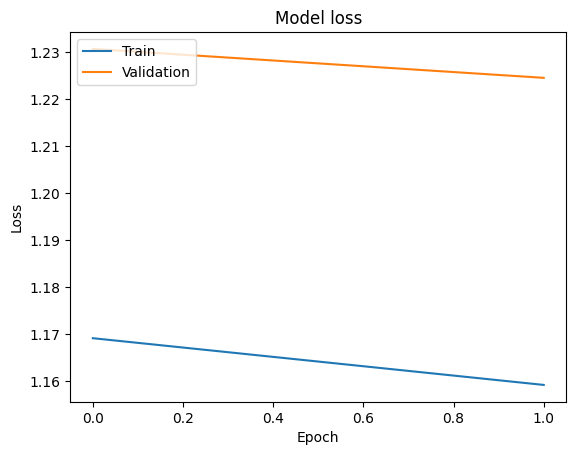

In [24]:
import matplotlib.pyplot as plt

# Assuming history is the object returned by model.fit()
history = model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=2, callbacks=callbacks, batch_size=32)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
# save chart to file
plt.savefig('loss_chart.png')

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_23/1294725119.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


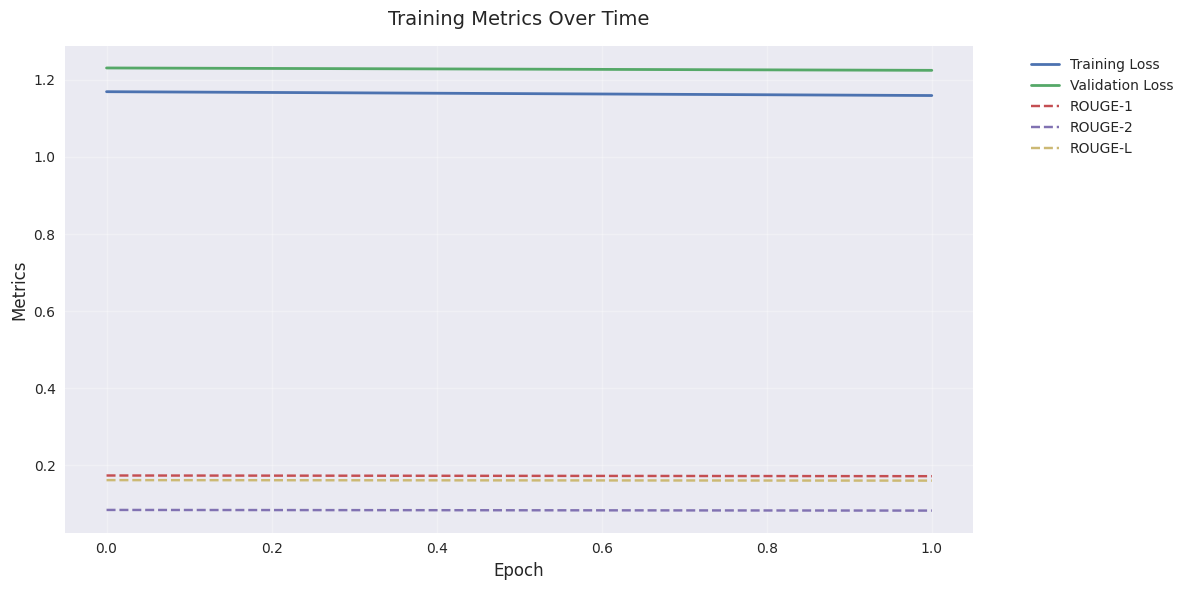

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and figure size
plt.style.use('seaborn')
plt.figure(figsize=(12, 6))

# Plot metrics
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.plot(history.history['rouge1'], label='ROUGE-1', linestyle='--')
plt.plot(history.history['rouge2'], label='ROUGE-2', linestyle='--')
plt.plot(history.history['rougeL'], label='ROUGE-L', linestyle='--')

# Customize chart
plt.title('Training Metrics Over Time', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Save with high quality
plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
model.save_pretrained("./summarization_model")
tokenizer.save_pretrained("./summarization_model")

('./summarization_model/tokenizer_config.json',
 './summarization_model/special_tokens_map.json',
 './summarization_model/spiece.model',
 './summarization_model/added_tokens.json',
 './summarization_model/tokenizer.json')

In [28]:
!zip -r summarization_model.zip /kaggle/working/summarization_model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/summarization_model/ (stored 0%)
  adding: kaggle/working/summarization_model/generation_config.json (deflated 29%)
  adding: kaggle/working/summarization_model/tokenizer_config.json (deflated 95%)
  adding: kaggle/working/summarization_model/config.json (deflated 62%)
  adding: kaggle/working/summarization_model/special_tokens_map.json (deflated 85%)
  adding: kaggle/working/summarization_model/tokenizer.json (deflated 74%)
  adding: kaggle/working/summarization_model/tf_model.h5 (deflated 16%)
  adding: kaggle/working/summarization_model/spiece.model (deflated 48%)


In [29]:
from IPython.display import FileLink
FileLink(r'summarization_model.zip')

/kaggle/working/summarization_model.zip

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
import tensorflow as tf

# Load the model and tokenizer
model_path = "./summarization_model"
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
# Function to summarize text
def summarize_text(text):
    inputs = tokenizer("summarize: " + text, return_tensors="tf", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Test the summarization
test_text = "Machine Learning adalah cabang dari kecerdasan buatan (AI) yang memungkinkan komputer belajar dari data tanpa harus diprogram secara eksplisit. Proses ini melibatkan pengembangan model matematika yang mampu mengenali pola atau hubungan dalam data. Algoritma machine learning dapat diklasifikasikan menjadi tiga kategori utama: supervised learning, unsupervised learning, dan reinforcement learning. Supervised learning menggunakan data berlabel untuk memprediksi hasil tertentu, sedangkan unsupervised learning mengidentifikasi struktur tersembunyi dalam data tanpa label. Dalam reinforcement learning, model belajar melalui trial and error dengan menerima reward atau penalti dari lingkungannya. Beberapa algoritma populer meliputi regresi linear, decision tree, k-nearest neighbors, dan neural networks. Machine learning digunakan secara luas di berbagai bidang seperti pengenalan wajah, analisis prediktif, sistem rekomendasi, dan pemrosesan bahasa alami. Keberhasilan model machine learning sangat bergantung pada kualitas data, teknik praproses data, dan parameter algoritma yang digunakan. Tantangan utama dalam machine learning mencakup overfitting, underfitting, dan bias data. Dengan berkembangnya teknologi, machine learning semakin memainkan peran penting dalam solusi berbasis data di era digital ini."
summary = summarize_text(test_text)
print("Summary:", summary)